In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dim = int(sqrt(len(df.columns)-1))
print(dim)

28


In [5]:
ix_sample = 8
sample = df.drop(columns='label').iloc[[ix_sample]].values.reshape(dim,dim)/255

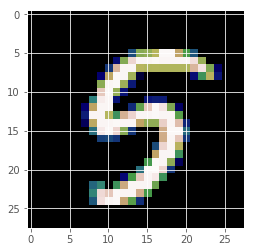

In [6]:
from PIL import Image
from matplotlib import cm
from matplotlib.pyplot import imshow
%matplotlib inline
im = Image.fromarray(np.uint8(cm.gist_earth(sample)*255))
imshow(im)

In [7]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data, dtype=np.int16).reshape(-1)
    return np.eye(nb_classes,dtype=np.int8)[targets]

In [8]:
def generate_submission(model, x_test):
    import csv
    csv_file = open(path+'/submission.csv', 'w', newline='', encoding='utf-8')
    writer = csv.writer(csv_file)
    writer.writerow(['ImageId','Label'])
    pred = model.predict(x_test)
    #ix = 155
    #im = Image.fromarray(np.uint8(cm.gist_earth(df.values[ix].reshape(dim,dim))*255))
    #imshow(im)
    #print(levels[np.argmax(pred[ix])])
    for ix, p in enumerate(pred):
        writer.writerow([ix+1, levels[np.argmax(p)]])
    csv_file.close()

In [9]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [10]:
from sklearn.model_selection import train_test_split
labels = df['label'].values
labels, levels = pd.factorize(labels)
classes = len(np.unique(labels))
y = indices_to_one_hot(labels, classes)
data = df.drop(columns=['label']).values/255
x_train, x_test, y_train, y_test = train_test_split(data,y, train_size=0.75)

In [11]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
print("classes:", classes)
print(levels)

31500
10500
31500
10500
classes: 10
[1 0 4 7 3 5 8 9 2 6]


In [12]:
print(y_train.shape)

(31500, 10)


In [ ]:
### Simple NN
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(input_shape,))
dense1 = Dense(units=1000, activation='relu')(inputs)
dense2 = Dense(units=1000, activation='sigmoid')(dense1)
dense3 = Dense(units=1000, activation='sigmoid')(dense2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
EPOCHS = 100
BATCH_SIZE = 256
path = 'NN'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

In [ ]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
## some visual testing

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
test_df = pd.read_csv('data/test.csv') ### 0.96785
generate_submission(model, test_df.values/255)

In [ ]:
### CNN
from keras.layers import Dense, Input, Conv2D, MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filters = 10
kernel_size = 4
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)
conv1 = Conv2D(filters = filters, kernel_size = kernel_size)(reshape)
max1 = MaxPooling2D()(conv1)
flat1=Flatten()(max1)
dense1 = Dense(units=1000, activation='relu')(flat1)
dense2 = Dense(units=1000, activation='sigmoid')(dense1)
dense3 = Dense(units=1000, activation='sigmoid')(dense2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

print(model.summary())

lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

In [ ]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
test_df = pd.read_csv('data/test.csv').values/255 ### 0.97671
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [ ]:
### CNN + dropout
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


filters = 10
kernel_size = 4
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)
conv1 = Conv2D(filters = filters, kernel_size = kernel_size)(reshape)
max1 = MaxPooling2D()(conv1)
flat1=Flatten()(max1)
dense1 = Dense(units=1000, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=1000, activation='sigmoid')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=1000, activation='sigmoid')(drop2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

print(model.summary())


lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN+d'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

In [ ]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
test_df = pd.read_csv('data/test.csv').values/255 ### 0.98085
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [ ]:
### CNN bigger + dropout
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


filters = 100
kernel_size = 4
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)
conv1 = Conv2D(filters = filters, kernel_size = kernel_size)(reshape)
max1 = MaxPooling2D()(conv1)
conv2 = Conv2D(filters = filters, kernel_size = kernel_size)(max1)
max2 = MaxPooling2D()(conv2)
flat1=Flatten()(max2)
dense1 = Dense(units=200, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=400, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=200, activation='sigmoid')(drop2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

print(model.summary())


lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 100
BATCH_SIZE = 256
path = 'bCNN+d'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

In [ ]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
test_df = pd.read_csv('data/test.csv').values ### 0.98757
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [ ]:
### CNN bigger + dropout
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, SpatialDropout2D
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


filters = 100
kernel_sizes = [6,4]
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)

conv1 = Conv2D(filters = filters, kernel_size = kernel_sizes[0])(reshape)
max1 = MaxPooling2D()(conv1)
spatial = SpatialDropout2D(0.2)(max1)
conv2 = Conv2D(filters = filters, kernel_size = kernel_sizes[1])(spatial)
max2 = MaxPooling2D()(conv2)
flat1=Flatten()(max2)
dense1 = Dense(units=800, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=400, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=200, activation='sigmoid')(drop2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)

print(model.summary())


lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN+d+Sd'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

In [ ]:
plot_history(history)

In [ ]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
test_df = pd.read_csv('data/test.csv').values/255 ### 0.99014
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [13]:
### CNN OVERKILL
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, SpatialDropout2D
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


filters = 400
kernel_sizes = [4,2,2]
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(dim,dim,))
reshape = Reshape((dim, dim, 1))(inputs)

conv1 = Conv2D(filters = filters, kernel_size = kernel_sizes[0])(reshape)
max1 = MaxPooling2D()(conv1)
spatial = SpatialDropout2D(0.4)(max1)
conv2 = Conv2D(filters = filters, kernel_size = kernel_sizes[1])(spatial)
max2 = MaxPooling2D()(conv2)
spatial2 = SpatialDropout2D(0.2)(max2)
conv3 = Conv2D(filters = filters, kernel_size = kernel_sizes[1])(spatial2)
max3 = MaxPooling2D()(conv3)
flat1=Flatten()(max3)
dense1 = Dense(units=800, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=400, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=200, activation='relu')(drop2)
drop3 = Dropout(0.5)(dense3)
dense4 = Dense(units=100, activation='relu')(drop3)
output = Dense(units=output_shape, activation='softmax')(dense4)

model = Model(inputs=inputs, outputs=output)

print(model.summary())


lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN+overkill'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0],dim,dim)
x_test = x_test.reshape(x_test.shape[0],dim,dim)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    callbacks = [checkpoint, early_stopping, reduceLR],validation_data=(x_test, y_test), class_weight='auto')

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 400)       6800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 400)       0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 12, 12, 400)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 400)       640400    
_________________________________________________________________
max

Epoch 15/100
31500/31500 [==============================] - 21s 656us/step - loss: 0.3520 - acc: 0.9060 - val_loss: 0.1265 - val_acc: 0.9691
Epoch 16/100
31500/31500 [==============================] - 21s 661us/step - loss: 0.3353 - acc: 0.9109 - val_loss: 0.1111 - val_acc: 0.9737
Epoch 17/100
31500/31500 [==============================] - 21s 660us/step - loss: 0.3070 - acc: 0.9200 - val_loss: 0.1036 - val_acc: 0.9758
Epoch 18/100
31500/31500 [==============================] - 21s 657us/step - loss: 0.2958 - acc: 0.9224 - val_loss: 0.1094 - val_acc: 0.9743
Epoch 19/100
31500/31500 [==============================] - 21s 660us/step - loss: 0.2684 - acc: 0.9314 - val_loss: 0.0991 - val_acc: 0.9775
Epoch 20/100
31500/31500 [==============================] - 21s 658us/step - loss: 0.2558 - acc: 0.9350 - val_loss: 0.0977 - val_acc: 0.9778
Epoch 21/100
31500/31500 [==============================] - 21s 657us/step - loss: 0.2474 - acc: 0.9364 - val_loss: 0.0982 - val_acc: 0.9777
Epoch 22/100


Epoch 43/100
31500/31500 [==============================] - 21s 653us/step - loss: 0.0968 - acc: 0.9755 - val_loss: 0.0723 - val_acc: 0.9850
Epoch 44/100
31500/31500 [==============================] - 21s 651us/step - loss: 0.1059 - acc: 0.9732 - val_loss: 0.0715 - val_acc: 0.9845
Epoch 45/100
31500/31500 [==============================] - 21s 654us/step - loss: 0.1031 - acc: 0.9742 - val_loss: 0.0701 - val_acc: 0.9850
Epoch 46/100
31500/31500 [==============================] - 21s 655us/step - loss: 0.0992 - acc: 0.9750 - val_loss: 0.0700 - val_acc: 0.9850
Epoch 47/100
31500/31500 [==============================] - 21s 654us/step - loss: 0.1047 - acc: 0.9735 - val_loss: 0.0730 - val_acc: 0.9850
Epoch 48/100
31500/31500 [==============================] - 21s 655us/step - loss: 0.0944 - acc: 0.9770 - val_loss: 0.0703 - val_acc: 0.9849
Epoch 49/100
31500/31500 [==============================] - 21s 655us/step - loss: 0.0978 - acc: 0.9756 - val_loss: 0.0690 - val_acc: 0.9847
Epoch 50/100


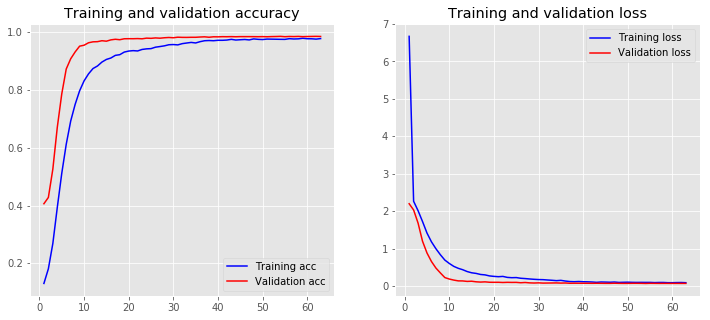

In [14]:
plot_history(history)

In [15]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1149    0    0    3    1    1    3    0    1    2]
 [   0 1028    0    0    0    0    1    1    1    0]
 [   2    1  997    2    0    0    2   11    2    0]
 [   2    0    0 1065    0    0    2    5    2    0]
 [   0    0    0    1 1079    3    4    1    8    0]
 [   1    3    0    0    1  916    8    2    0    4]
 [   0    0    2    1    2    2 1033    6    2    2]
 [   0    3    7    2    0    2    4 1030    0    0]
 [   7    1    0   10    1    0    4    0 1057    0]
 [   0    2    2    0    0    2    2    0    1  998]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1160
           1       0.99      1.00      0.99      1031
           2       0.99      0.98      0.98      1017
           3       0.98      0.99      0.99      1076
           4       1.00      0.98      0.99      1096
           5       0.99      0.98      0.98       935
           6       0.97      0.98      0.98      1050
           7       0.98      0.98   

In [17]:
test_df = pd.read_csv('data/test.csv').values/255 ### 0.99014
test_df = test_df.reshape(test_df.shape[0],dim,dim)
generate_submission(model, test_df)

In [35]:
### CNN OVERKILL  w/ data augmentation
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, SpatialDropout2D
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=12,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

filters = 400
kernel_sizes = [3,3,3]

x_train = x_train.reshape(-1,dim,dim,1)
x_test = x_test.reshape(-1,dim,dim,1)

print(x_train.shape)
print(x_test.shape)

input_shape = x_train.shape[1]
output_shape = y_train.shape[1]
datagen.fit(x_train)

inputs = Input(shape=(dim,dim,1))
#reshape = Reshape((dim, dim, 1))(inputs)

conv1 = Conv2D(filters = 32, kernel_size = kernel_sizes[0], padding='same')(inputs)
conv2 = Conv2D(filters = 64, kernel_size = kernel_sizes[0], padding='same')(conv1)
conv3 = Conv2D(filters = 128, kernel_size = kernel_sizes[0], padding='same')(conv2)
max1 = MaxPooling2D()(conv3)
spatial = SpatialDropout2D(0.4)(max1)
conv4 = Conv2D(filters = 128, kernel_size = kernel_sizes[1], padding='same')(spatial)
conv5 = Conv2D(filters = 128, kernel_size = kernel_sizes[1], padding='same')(conv4)
max2 = MaxPooling2D()(conv5)
spatial2 = SpatialDropout2D(0.2)(max2)
conv6 = Conv2D(filters = 192, kernel_size = kernel_sizes[2], padding='same')(spatial2)
#conv6 = Conv2D(filters = 128, kernel_size = kernel_sizes[2])(conv5)
max3 = MaxPooling2D()(conv6)
flat1=Flatten()(max3)
dense1 = Dense(units=1600, activation='relu')(flat1)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(units=800, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
dense3 = Dense(units=400, activation='relu')(drop2)
drop3 = Dropout(0.5)(dense3)
dense4 = Dense(units=200, activation='relu')(drop3)
output = Dense(units=output_shape, activation='softmax')(dense4)

model = Model(inputs=inputs, outputs=output)

print(model.summary())


lr = 1e-4
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


EPOCHS = 100
BATCH_SIZE = 256
path = 'CNN+overkill+da'
if not os.path.exists(path):
    os.makedirs(path)

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=9, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=3,verbose = 1)
print(x_train.shape)


history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS, validation_data=(x_test, y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // BATCH_SIZE
                              , callbacks = [checkpoint, early_stopping, reduceLR], class_weight='auto')

(31500, 28, 28, 1)
(10500, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
spatial_dropout2d_21 (Spatia (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14

Epoch 18/100
123/123 [==============================] - 16s 131ms/step - loss: 0.1743 - acc: 0.9492 - val_loss: 0.0422 - val_acc: 0.9879
Epoch 19/100
123/123 [==============================] - 16s 130ms/step - loss: 0.1668 - acc: 0.9479 - val_loss: 0.0456 - val_acc: 0.9870
Epoch 20/100
123/123 [==============================] - 16s 130ms/step - loss: 0.1599 - acc: 0.9530 - val_loss: 0.0427 - val_acc: 0.9878
Epoch 21/100
123/123 [==============================] - 16s 130ms/step - loss: 0.1591 - acc: 0.9526 - val_loss: 0.0509 - val_acc: 0.9861
Epoch 22/100
122/123 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9536Epoch 00022: val_acc did not improve

Epoch 00022: reducing learning rate to 3.2999999166349884e-05.
123/123 [==============================] - 16s 132ms/step - loss: 0.1557 - acc: 0.9537 - val_loss: 0.0544 - val_acc: 0.9845
Epoch 23/100
123/123 [==============================] - 16s 132ms/step - loss: 0.1446 - acc: 0.9578 - val_loss: 0.0389 - val_acc: 0.988

Epoch 00046: early stopping


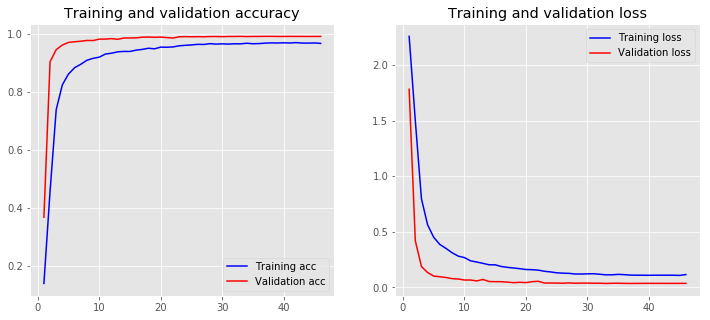

In [36]:
plot_history(history)

In [37]:
weight_file = path + '/weights.hdf5'
model.load_weights(weight_file)
y_pred = model.predict(x_test)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1140    0    0    3    0    0    0    0    2    0]
 [   0 1067    0    0    0    0    2    0    0    3]
 [   2    0 1035    1    0    0    0    4    0    2]
 [   1    0    6 1127    0    0    2    1    1    0]
 [   0    0    0    0 1059    4    1    1    7    0]
 [   0    0    0    0    2  909    2    0    0    6]
 [   1    2    2    1    0    1  983    6    3    0]
 [   0    0    5    2    0    1    2 1032    0    0]
 [   3    2    0    7    0    0    4    0 1005    0]
 [   0    1    2    0    0    0    3    0    1 1041]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1145
           1       1.00      1.00      1.00      1072
           2       0.99      0.99      0.99      1044
           3       0.99      0.99      0.99      1138
           4       1.00      0.99      0.99      1072
           5       0.99      0.99      0.99       919
           6       0.98      0.98      0.98       999
           7       0.99      0.99   

In [39]:
test_df = pd.read_csv('data/test.csv').values/255 ### 0.99385
test_df = test_df.reshape(test_df.shape[0],dim,dim, 1)
generate_submission(model, test_df)